Stock Market Prediction using Numerical and Textual Analysis

In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\devil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# reading the datasets into pandas
stock_price = pd.read_csv('D:/abcd/TSLA.csv')

In [3]:
stock_headlines = pd.read_csv('D:/abcd/india-news-headlines.csv')

In [4]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-06-15,183.557999,199.768005,181.699997,198.179993,198.179993,78486000
1,2020-06-16,202.369995,202.576004,192.477997,196.425995,196.425995,70255500
2,2020-06-17,197.542007,201.000000,196.514008,198.358002,198.358002,49454000
3,2020-06-18,200.600006,203.839996,198.893997,200.792007,200.792007,48759500
4,2020-06-19,202.556000,203.194000,198.268005,200.179993,200.179993,43398500


In [5]:
len(stock_price), len(stock_headlines)

(252, 3424067)

In [6]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

Stock Prices

In [7]:
#dropping any null entries in our data
stock_price.dropna(axis=0, inplace=True)

In [8]:
# dropping duplicates in data
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-06-15,198.179993,183.557999,199.768005,181.699997,78486000
2020-06-16,196.425995,202.369995,202.576004,192.477997,70255500
2020-06-17,198.358002,197.542007,201.000000,196.514008,49454000
2020-06-18,200.792007,200.600006,203.839996,198.893997,48759500
2020-06-19,200.179993,202.556000,203.194000,198.268005,43398500
...,...,...,...,...,...
2021-06-08,603.590027,623.010010,623.090027,595.500000,26053400
2021-06-09,598.780029,602.169983,611.789978,597.630005,16584600
2021-06-10,610.119995,603.880005,616.590027,600.500000,23919600


Stock Headlines

In [9]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


Combining both Prices and Headlines

In [10]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-06-15,198.179993,183.557999,199.768005,181.699997,78486000.0,Horoscope Today; 15 June 2020: Check astrologi...
2020-06-16,196.425995,202.369995,202.576004,192.477997,70255500.0,Pattachitra; Madhubani; kalamkari; zardosi; an...
2020-06-17,198.358002,197.542007,201.000000,196.514008,49454000.0,"Bus rams 22 two-wheelers; kills one,Agri dept ..."
2020-06-18,200.792007,200.600006,203.839996,198.893997,48759500.0,"Three killed in two road accidents,Two detaine..."
2020-06-19,200.179993,202.556000,203.194000,198.268005,43398500.0,Bengaluru: Motorist who drove with cabbie on b...
...,...,...,...,...,...,...
2020-12-24,661.770020,642.989990,666.090027,641.000000,22865600.0,How to set the mood for sex during cold winter...
2020-12-28,663.690002,674.510010,681.400024,660.799988,32278600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,665.989990,661.000000,669.900024,655.000000,22910800.0,Man recovers charred remains of 'thief' from h...
2020-12-30,694.780029,672.000000,696.599976,668.359985,42846000.0,Numerology Readings 30 December 2020: Predicti...


In [11]:
#Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-06-15,198.179993,183.557999,199.768005,181.699997,78486000.0,Horoscope Today; 15 June 2020: Check astrologi...,,,,
2020-06-16,196.425995,202.369995,202.576004,192.477997,70255500.0,Pattachitra; Madhubani; kalamkari; zardosi; an...,,,,
2020-06-17,198.358002,197.542007,201.000000,196.514008,49454000.0,"Bus rams 22 two-wheelers; kills one,Agri dept ...",,,,
2020-06-18,200.792007,200.600006,203.839996,198.893997,48759500.0,"Three killed in two road accidents,Two detaine...",,,,
2020-06-19,200.179993,202.556000,203.194000,198.268005,43398500.0,Bengaluru: Motorist who drove with cabbie on b...,,,,


In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-06-15,198.179993,183.557999,199.768005,181.699997,78486000.0,Horoscope Today; 15 June 2020: Check astrologi...,-0.9997,0.117,0.813,0.069
2020-06-16,196.425995,202.369995,202.576004,192.477997,70255500.0,Pattachitra; Madhubani; kalamkari; zardosi; an...,-0.9998,0.139,0.771,0.090
2020-06-17,198.358002,197.542007,201.000000,196.514008,49454000.0,"Bus rams 22 two-wheelers; kills one,Agri dept ...",-0.9985,0.110,0.802,0.088
2020-06-18,200.792007,200.600006,203.839996,198.893997,48759500.0,"Three killed in two road accidents,Two detaine...",-0.9997,0.129,0.791,0.081
2020-06-19,200.179993,202.556000,203.194000,198.268005,43398500.0,Bengaluru: Motorist who drove with cabbie on b...,-0.9998,0.136,0.781,0.083


In [13]:
# dropping unwanted 'headline_text' and rearranging columns
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-06-15,198.179993,-0.9997,0.117,0.813,0.069,183.557999,199.768005,181.699997,78486000.0
2020-06-16,196.425995,-0.9998,0.139,0.771,0.090,202.369995,202.576004,192.477997,70255500.0
2020-06-17,198.358002,-0.9985,0.110,0.802,0.088,197.542007,201.000000,196.514008,49454000.0
2020-06-18,200.792007,-0.9997,0.129,0.791,0.081,200.600006,203.839996,198.893997,48759500.0
2020-06-19,200.179993,-0.9998,0.136,0.781,0.083,202.556000,203.194000,198.268005,43398500.0


Feature engineering of the Combined Data

In [14]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [15]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,140.000000,140.00000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02
mean,413.046042,-0.98536,0.126850,0.795386,0.077707,411.499287,422.778615,399.779414,6.163217e+07
std,129.818261,0.16878,0.016726,0.023516,0.011840,128.035317,130.905917,125.047121,3.245081e+07
min,191.947998,-0.99990,0.082000,0.742000,0.047000,183.557999,197.195999,181.699997,1.735770e+07
25%,306.780006,-0.99980,0.116000,0.781000,0.069000,303.601502,315.985001,295.309998,3.798162e+07
50%,417.725006,-0.99980,0.127000,0.792500,0.077500,415.800003,426.784988,406.574996,5.122875e+07
75%,449.007507,-0.99960,0.138000,0.810750,0.085000,451.015000,462.424500,438.647492,8.079112e+07
max,705.669983,0.99740,0.169000,0.854000,0.127000,699.989990,718.719971,691.119995,2.221262e+08


In [16]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2020-06-15 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     140 non-null    float64
 1   compound  140 non-null    float64
 2   negative  140 non-null    float64
 3   neutral   140 non-null    float64
 4   positive  140 non-null    float64
 5   Open      140 non-null    float64
 6   High      140 non-null    float64
 7   Low       140 non-null    float64
 8   Volume    140 non-null    float64
dtypes: float64(9)
memory usage: 10.9 KB


Stock Data Analysis

Text(0, 0.5, 'Close Price (INR)')

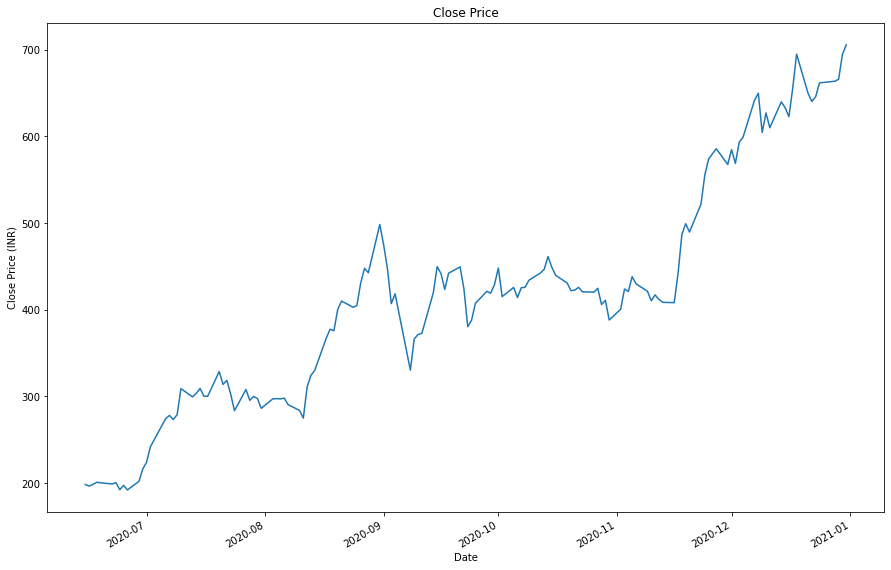

In [17]:
#Setting plot size and labels
plt.figure(figsize=(15,10))

stock_data['Close'].plot()


plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [18]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-23,199.022284,-0.999586,0.127571,0.792143,0.080429,198.056002,202.079143,194.951429,5.057029e+07
2020-06-24,198.163714,-0.999586,0.127429,0.791429,0.081286,200.236574,202.137427,196.226859,4.718629e+07
2020-06-25,198.273714,-0.999600,0.126143,0.797857,0.076143,198.591433,201.368855,195.505716,4.376014e+07
2020-06-26,197.357999,-0.999800,0.131857,0.792571,0.075714,198.793431,201.083141,194.714286,4.302021e+07


<AxesSubplot:>

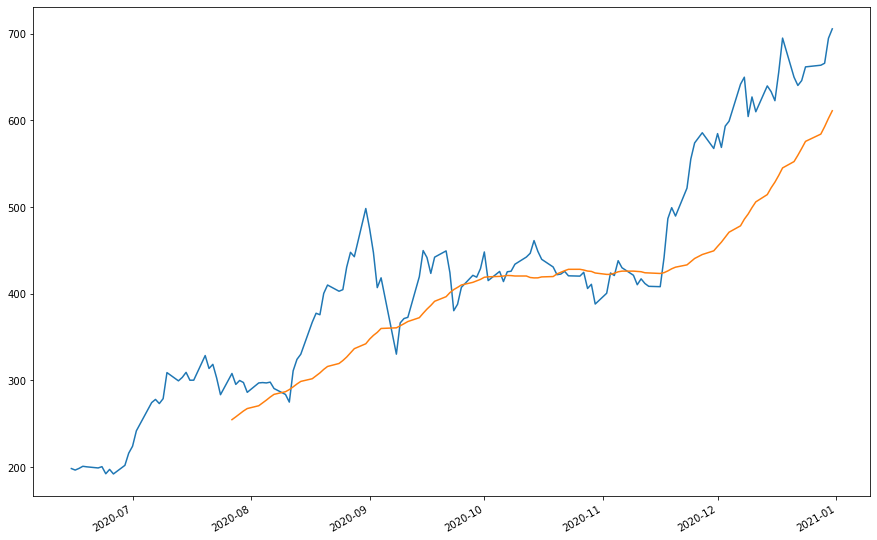

In [37]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [20]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-06-15,198.179993,-0.9997,0.117,0.813,0.069,183.557999,199.768005,181.699997,78486000.0
2020-06-16,196.425995,-0.9998,0.139,0.771,0.090,202.369995,202.576004,192.477997,70255500.0
2020-06-17,198.358002,-0.9985,0.110,0.802,0.088,197.542007,201.000000,196.514008,49454000.0
2020-06-18,200.792007,-0.9997,0.129,0.791,0.081,200.600006,203.839996,198.893997,48759500.0
2020-06-19,200.179993,-0.9998,0.136,0.781,0.083,202.556000,203.194000,198.268005,43398500.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,661.770020,-0.9971,0.082,0.854,0.064,642.989990,666.090027,641.000000,22865600.0
2020-12-28,663.690002,-0.9997,0.126,0.789,0.085,674.510010,681.400024,660.799988,32278600.0
2020-12-29,665.989990,-0.9998,0.136,0.774,0.090,661.000000,669.900024,655.000000,22910800.0
2020-12-30,694.780029,-0.9998,0.126,0.797,0.077,672.000000,696.599976,668.359985,42846000.0


DATA FOR MODELLING

In [21]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 111
Number of records in Test Data: 29


In [22]:
# predicting one step ahead
steps_to_predict = 1


close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2020-06-16    196.425995
2020-06-17    198.358002
2020-06-18    200.792007
2020-06-19    200.179993
2020-06-22    198.863998
                 ...    
2020-12-24    661.770020
2020-12-28    663.690002
2020-12-29    665.989990
2020-12-30    694.780029
2020-12-31    705.669983
Name: Close, Length: 139, dtype: float64

In [23]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2020-06-16,196.425995,198.358002,-0.9998,-0.9985,70255500.0,202.369995,202.576004,192.477997
2020-06-17,198.358002,200.792007,-0.9985,-0.9997,49454000.0,197.542007,201.000000,196.514008
2020-06-18,200.792007,200.179993,-0.9997,-0.9998,48759500.0,200.600006,203.839996,198.893997
2020-06-19,200.179993,198.863998,-0.9998,-0.9997,43398500.0,202.556000,203.194000,198.268005
2020-06-22,198.863998,200.356003,-0.9997,-0.9999,31812000.0,199.990005,201.776001,198.003998
2020-06-23,200.356003,192.169998,-0.9999,-0.9997,31826500.0,199.776001,202.399994,198.802002
2020-06-24,192.169998,197.195999,-0.9997,-0.9999,54798000.0,198.822006,200.175995,190.628006
2020-06-25,197.195999,191.947998,-0.9999,-0.9999,46272500.0,190.854004,197.195999,187.429993
2020-06-26,191.947998,201.869995,-0.9999,-0.9997,44274500.0,198.955994,199.000000,190.973999
2020-06-29,201.869995,215.962006,-0.9997,-0.9998,45132000.0,193.802002,202.000000,189.703995


In [24]:
#close price shifted set as the target var
y = data['close_price_shifted']
y

2020-06-16    198.358002
2020-06-17    200.792007
2020-06-18    200.179993
2020-06-19    198.863998
2020-06-22    200.356003
                 ...    
2020-12-23    661.770020
2020-12-24    663.690002
2020-12-28    665.989990
2020-12-29    694.780029
2020-12-30    705.669983
Name: close_price_shifted, Length: 138, dtype: float64

In [25]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2020-06-16,196.425995,-0.9998,-0.9985,70255500.0,202.369995,202.576004,192.477997
2020-06-17,198.358002,-0.9985,-0.9997,49454000.0,197.542007,201.000000,196.514008
2020-06-18,200.792007,-0.9997,-0.9998,48759500.0,200.600006,203.839996,198.893997
2020-06-19,200.179993,-0.9998,-0.9997,43398500.0,202.556000,203.194000,198.268005
2020-06-22,198.863998,-0.9997,-0.9999,31812000.0,199.990005,201.776001,198.003998
...,...,...,...,...,...,...,...
2020-12-23,645.979980,-0.9996,-0.9971,33173000.0,632.200012,651.500000,622.570007
2020-12-24,661.770020,-0.9971,-0.9997,22865600.0,642.989990,666.090027,641.000000
2020-12-28,663.690002,-0.9997,-0.9998,32278600.0,674.510010,681.400024,660.799988
2020-12-29,665.989990,-0.9998,-0.9998,22910800.0,661.000000,669.900024,655.000000


In [26]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-9.82196684e-01, -9.99899865e-01, -9.98598107e-01,
         -4.83340455e-01, -9.52379415e-01, -9.78454297e-01,
         -9.79007323e-01],
        [-9.74515541e-01, -9.98598107e-01, -9.99799730e-01,
         -6.86511353e-01, -9.72343968e-01, -9.84765836e-01,
         -9.62223130e-01],
        [-9.64838589e-01, -9.99799730e-01, -9.99899865e-01,
         -6.93294623e-01, -9.59698621e-01, -9.73392294e-01,
         -9.52325685e-01],
        [-9.67271793e-01, -9.99899865e-01, -9.99799730e-01,
         -7.45656192e-01, -9.51610253e-01, -9.75979362e-01,
         -9.54928941e-01],
        [-9.72503837e-01, -9.99799730e-01, -1.00000000e+00,
         -8.58823012e-01, -9.62221079e-01, -9.81658128e-01,
         -9.56026843e-01],
        [-9.66572024e-01, -1.00000000e+00, -9.99799730e-01,
         -8.58681389e-01, -9.63106022e-01, -9.79159177e-01,
         -9.52708256e-01],
        [-9.99117387e-01, -9.99799730e-01, -1.00000000e+00,
         -6.34315825e-01, -9.67050954e-01, -9.88065790e-01

Data divided for training and test datasets

In [27]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)


Number of rows and columns in Training set X: (111, 7) and y: (111, 1)
Number of rows and columns in Test set X: (26, 7) and y: (26, 1)


In [33]:
#reshaping dataset
X_train = np.reshape(X_train, (X_train.shape[0], 7, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 7, X_test.shape[1]))

Data Modelling

In [34]:
# seed set to achieve consistent and less random predictions
np.random.seed(2020)

# setting the architecture for the data model
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 100)            40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [35]:
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, batch_size=8, epochs=10, verbose=1)

Epoch 1/10
14/14 [==============================] - 57s 24ms/step - loss: 0.1324
Epoch 2/10
14/14 [==============================] - 0s 20ms/step - loss: 0.0531
Epoch 3/10
14/14 [==============================] - 0s 22ms/step - loss: 0.0373
Epoch 4/10
14/14 [==============================] - 0s 22ms/step - loss: 0.0250
Epoch 5/10
14/14 [==============================] - 0s 19ms/step - loss: 0.0227
Epoch 6/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0295
Epoch 7/10
14/14 [==============================] - 0s 20ms/step - loss: 0.0213
Epoch 8/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0211
Epoch 9/10
14/14 [==============================] - 0s 20ms/step - loss: 0.0169
Epoch 10/10
14/14 [==============================] - 0s 19ms/step - loss: 0.0223
